## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [21]:
#!pip install matplotlib
#!pip install numpy
#!pip install pandas 

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

**QUESTION:** Load dataset and display some lines of the csv file.

In [23]:
df = pd.read_csv("ai4i2020.csv")
print(df.head())

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0  

**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

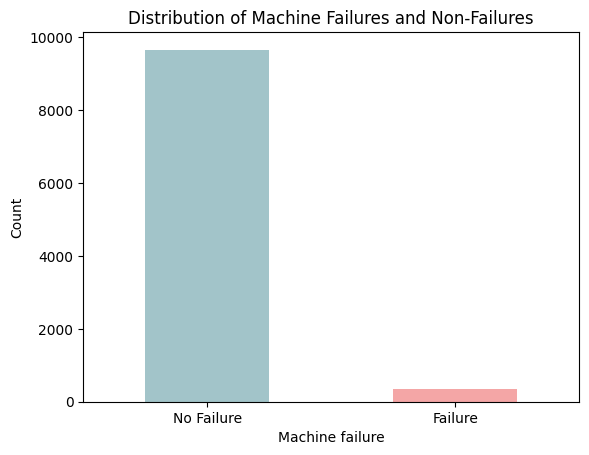

In [24]:
failure_counts = df['Machine failure'].value_counts()
failure_counts.plot(kind='bar', color=['#A2C4C9', '#F4A6A6'])
plt.xticks(ticks=[0, 1], labels=['No Failure', 'Failure'], rotation=0)
plt.ylabel('Count')
plt.title('Distribution of Machine Failures and Non-Failures')
plt.show()

**ANALYSIS QUESTION:** What do you observe?

"Write here your response"

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

"Write here your response"

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

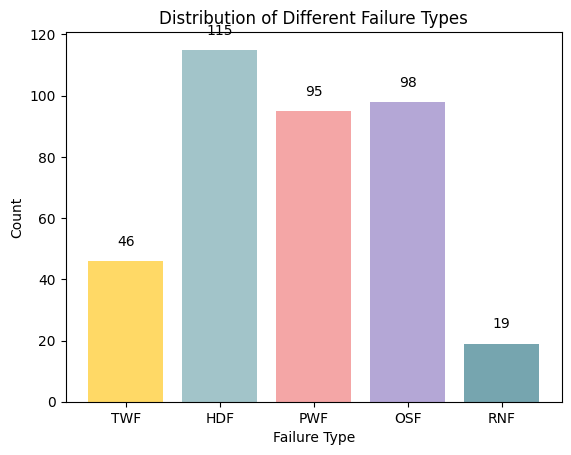

In [25]:
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
failure_counts = df[failure_types].sum()

colors = ['#FFD966', '#A2C4C9', '#F4A6A6', '#B4A7D6', '#76A5AF']
plt.bar(failure_counts.index, failure_counts.values, color=colors)
plt.xlabel('Failure Type')
plt.ylabel('Count')
plt.title('Distribution of Different Failure Types')
for i, v in enumerate(failure_counts.values):
    plt.text(i, v + 5, str(v), ha='center', fontsize=10)

plt.show()

**ANALYSIS QUESTION:** What do you observe?

"Write here your response"

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

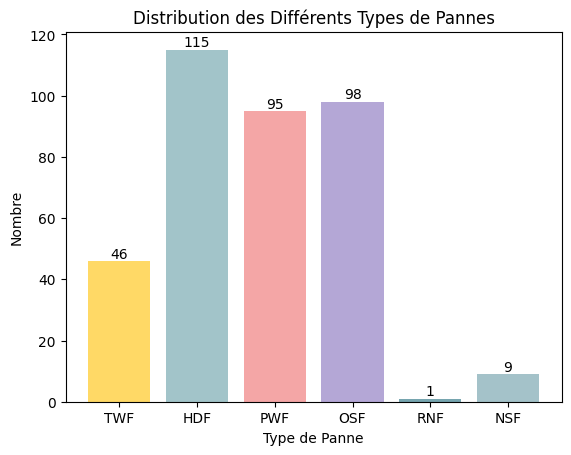

In [26]:
failed_machines = df[df['Machine failure'] == 1]

failure_counts = failed_machines[failure_types].sum()

failure_counts['NSF'] = (failed_machines[failure_types].sum(axis=1) == 0).sum()


colors = ['#FFD966', '#A2C4C9', '#F4A6A6', '#B4A7D6', '#76A5AF', '#A4C2C9']
plt.bar(failure_counts.index, failure_counts.values, color=colors)
plt.xlabel('Type de Panne')
plt.ylabel('Nombre')
plt.title('Distribution des Différents Types de Pannes')

for i, count in enumerate(failure_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=10)

plt.show()


**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

"Write your response here"

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

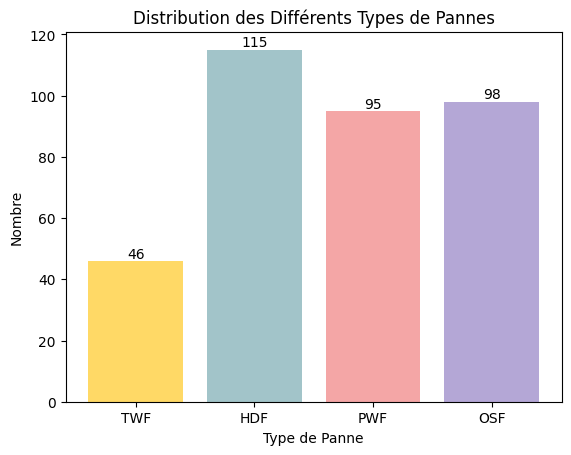

In [27]:
#on enlève RNF car apparait qu'une seule fois, car Random donc difficile à prédire et 18 fois où RNF vaut 1 et Machine failure = 0 donc problème 
#on enlève aussi les NSF: car on peut pas les prédire

failure_types_ok = ['TWF', 'HDF', 'PWF', 'OSF']
failed_machines = df[df['Machine failure'] == 1]

failure_counts = failed_machines[failure_types_ok].sum()


colors = ['#FFD966', '#A2C4C9', '#F4A6A6', '#B4A7D6']
plt.bar(failure_counts.index, failure_counts.values, color=colors)
plt.xlabel('Type de Panne')
plt.ylabel('Nombre')
plt.title('Distribution des Différents Types de Pannes')

for i, count in enumerate(failure_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=10)

plt.show()

**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to jsurtify your response.

"Write your response here"

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [ ]:
# Remove cases where RNF == 1 pour machine failure =0 ou =1
df = df[df['RNF'] == 0]

# Remove cases where Machine failure == 1 but no specific failure type is recorded
failure_types_ok = ['TWF', 'HDF', 'PWF', 'OSF']
df = df[~((df['Machine failure'] == 1) & (df[failure_types_ok].sum(axis=1) == 0))]

# Drop RNF column
df = df.drop(columns=['RNF'])
#add NF column = l'inverse de machine failure
df['NF'] = (df['Machine failure'] == 0).astype(int)
# Drop RNF column
df = df.drop(columns=['Machine failure'])

# Display first lines of the dataset
print(df.head())
print(len(df))  # Nombre total de lignes

X = df[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']]
Y = df[['TWF', 'HDF', 'PWF', 'OSF', 'NF']]

X_train, Y_train, X_test, Y_test = train_test_split (X, Y, test_size=0.2, random_state=42)

#coucou_suite

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  TWF  HDF  PWF  OSF  \
0                    1551         42.8                0    0    0    0    0   
1                    1408         46.3                3    0    0    0    0   
2                    1498         49.4                5    0    0    0    0   
3                    1433         39.5                7    0    0    0    0   
4                    1408         40.0                9    0    0    0    0   

   NF  
0   1  
1   1  
2   1  
3   1  
4   1  
9972


**QUESTION** Code below the model architecture

**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

"Write your response here"

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

**QUESTION** Code below the algorithms allowing to train model


**QUESTION** Plot the confusion matrix and the classification report

**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"